# Python codes for [Introduction to Computional Stochastic PDEs, CUP 2014](http://www.cambridge.org/gb/academic/subjects/mathematics/differential-and-integral-equations-dynamical-systems-and-co/introduction-computational-stochastic-pdes?format=PB&isbn=9780521728522)

[T. Shardlow](http://people.bath.ac.uk/tjs42/) Dec 2015
# Chapter 3





In [44]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import sys
if sys.version_info < (3,):
    try:
        from builtins import (bytes, dict, int, list, object, range, str,
                              ascii, chr, hex, input, next, oct, open,
                              pow, round, super, filter, map, zip)
        from future.builtins.disabled import (apply, cmp, coerce, execfile,
                                              file, long, raw_input,
                                              reduce, reload,
                                              unicode, xrange, StandardError)
    except:
        print("need future module")
#
from timeit import default_timer as timer

In addition to the Numpy and Matplotlib imports, we also import Scipy, which offers additional mathematics libraries. Particularly, we use sparse matrices and the nonlinear equation solve in `scipy.optimize`.

In [45]:
from math import *
# Numpy
import numpy as np
from numpy import matlib
# Plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Scipy
import scipy
from scipy import sparse
from scipy.sparse import linalg
from scipy import optimize

We start with the explicit Euler method.


In [46]:
def exp_euler(u0,T,N,d,fhandle):
    """
    A3.1 Page 90
    """
    Dt=T / N # set time step
    u=np.zeros((d,N + 1)) # prealloacte solution u
    t=np.linspace(0,T,N+1) # make time vector
    u[:,0]=u0 # set initial data
    u_n=np.copy(u0)
    for n in range(N):
        u_new=u_n + Dt * fhandle(u_n) # explicit Euler step
        u[:,n + 1]=u_new
        u_n=u_new
    return t,u

We show this code can be used for the initial-value problem $$ \frac{du}{dt}= \left(\begin{array}c u_1 (1-u_2)\\ u_2(u_1-1)\end{array}\right),\qquad u(0)=\left(\begin{array}c 0.5\\1 \end{array}\right).$$

Elapsed time  0.046017815142


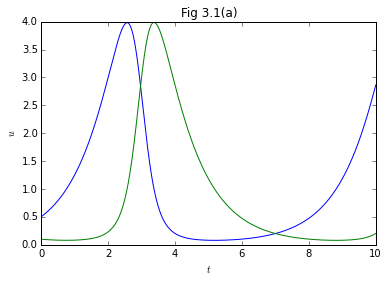

In [47]:
def f(u):
    """
    page 91
    """
    out=np.array([u[0]*(1-u[1]), u[1]*(u[0]-1)])
    return out
# Example
u0=[0.5,0.1]; T=10; N=int(1e4); d=2;
start=timer()
[t,u]=exp_euler(u0,T,N,d,f)
print("Elapsed time ", timer()-start)
plt.plot(t,u[0,:])
plt.plot(t,u[1,:])
s=plt.xlabel(r'$t$')
s=plt.ylabel(r'$u$')
s=plt.title('Fig 3.1(a)')

The implicit-Euler method provides more stability, but requires a nonlinear solve at each step.

Elapsed time 0.582945299091


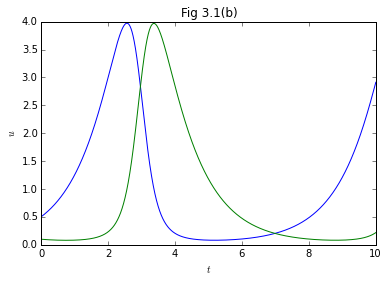

In [48]:
def imp_euler(u0,T,N,d,fhandle):
    """
    A3.1 Page 91
    """
    Dt=T / N # set time step 
    u=np.zeros((d,N + 1)) # preallocate solution u
    t=np.linspace(0,T,N+1) # set time
    u[:,0]=u0;     u_n=np.copy(u0) # set initial condition
    impeuler=(lambda u: u - u_n - Dt * fhandle(u))
    for n in range(N): # time loop 
        u_new=scipy.optimize.fsolve(impeuler,u_n,xtol=Dt**2)
        u[:,n + 1]=u_new
        u_n=u_new
    return t,u
# Example
u0=[0.5,0.1]; T=10; N=int(1e4); d=2
start=timer()
[t,u]=imp_euler(u0,T,N,d,f)
print("Elapsed time", timer()-start)
plt.plot(t,u[0,:])
plt.plot(t,u[1,:])
s=plt.xlabel(r'$t$')
s=plt.ylabel(r'$u$')  
s=plt.title('Fig 3.1(b)')

For the same number of steps, the implicit Euler method is ten-times slower than explicit Euler.

Let's examine the rate of converge of the explicit-Euler method, using two methods for estimating the approximation error.

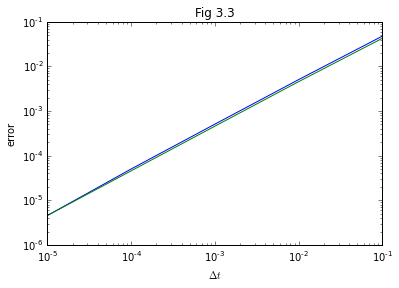

In [49]:
def exp_euler_conv(u0,T,Nref,d,fhandle,kappa):
    """
    A3.3 Page 94
    """
    t,uref=exp_euler(u0,T,Nref,d,fhandle) # compute reference soln
    uTref=uref[:,-1]
    dtref=T / Nref;     uTold=np.copy(uTref)
    dt=np.empty_like(kappa,dtype='float64');     uT=np.empty_like(dt)
    errA=np.empty_like(dt);     errB=np.empty_like(dt)    
    for k in range(kappa.size):
        N=Nref // kappa[k];        dt[k]=T / N
        t,u=exp_euler(u0,T,N,d,fhandle) # compute approximate soln
        uT=u[:,-1]
        errA[k]=np.linalg.norm(uTref - uT) # error by method A
        errB[k]=np.linalg.norm(uTold - uT) # error by method B
        uTold=np.copy(uT)
    return dt,errA,errB
# example
u0=np.array([0.5,0.1]);    T=1;    Nref=int(1e6);    d=2
kappa=np.array([10,1e2,1e3,1e4,1e5],dtype='int32')
[dt,errA,errB]=exp_euler_conv(u0,T,Nref,d,f,kappa)
s=plt.xlabel(r'$\Delta t$')
s=plt.ylabel(r'error')  
s=plt.loglog(dt,np.vstack([errA,errB]).T)
s=plt.title('Fig 3.3')

We turn now to the reaction-diffusion equation $$ u_t= u_{xx} +f(u)\quad \text{ with initial condition }u(0,x)=u_0(x)\quad \text{for} \quad x\in (a,b)$$ with either homogenous Dirichlet, homogeneous Neumann, or periodic boundary conditions. We start with the second-order finite-difference approximation to the Laplacian and semi-implicit Euler time stepping.

Again we use the `csc` matrices to represent the matrix, but rather than use `spsolve`, we employ `sparse.linalg.factorized` to generate an efficient way of repeatedly solving the linear system.

In [50]:
def pde_fd(u0,T,a,N,J,epsilon,fhandle,bctype):
    """
    A3.4 Page 109
    """
    Dt=T / N;     t=np.linspace(0,T,N+1)
    h=a / J;
    # set matrix A according to boundary conditions
    e=np.ones((J + 1,1))
    A=scipy.sparse.diags([-1,2,-1],[-1,0,1],
                         shape=(J+1,J+1),
                         format='csc')
    if 'd' == bctype.lower():
        ind=np.arange(1,J)
        A=A[:,ind]; A=A[ind,:]
    else:
        if 'p' == bctype.lower():
            ind=np.arange(0,J)
            A=A[:,ind]; A=A[ind,:]
            A[1,-1]=- 1; A[-1,1]=- 1
        else:
            if 'n' == bctype.lower():
                ind=np.arange(0,J + 1)
                A[0,1]= -2; A[-1,-2]= -2 
    EE=scipy.sparse.identity(ind.size,format='csc') + (Dt * epsilon/h**2) * A 
    ut=np.zeros((J + 1,t.size)) # initialize vectors
    ut[:,0]=u0; u_n=u0[ind] # set initial condition
    #
    EEinv=sparse.linalg.factorized(EE)
    #
    for k in range(N): # time loop
        fu=fhandle(u_n) # evaluate f(u_n)
        u_new=EEinv(u_n + Dt * fu) # linear solve for EE
        ut[ind,k + 1]=u_new
        u_n=u_new
    if bctype.lower() == 'p':
        ut[-1,:]=ut[0,:] # correct for periodic case  
    return t,ut

We implement the Nagumo reaction term $f(u)=u(1-u)(u+0.5)$. There are number of constructions in Numpy for making a real-valued function (i.e., a Python function that take arguments with `float64` data type) act on vectors. Here are two implementations of the same function. The first is straight forward; the second specifies data types and imports the `numba` module to improve efficiency.

In [51]:
def fNagumoNoVec(u):
    return u*(1-u)*(u+0.5)
#
from numba import vectorize, float64
@vectorize([float64(float64)])
def fNagumo(u):
    return u*(1-u)*(u+0.5)

Let's test the speed of three implementations to evaluate the rows and columns of a large matrix

In [52]:
N=int(1e3);M=int(1e3)
print("Compare speed of vectorized fNagumo")
X=np.random.randn(N,M)
start=timer()
for i in range(M):
    a=fNagumo(X[i,:])
end=timer()
print("Run time (by rows)", end-start, "secs using @vectorize")
start=timer()
for i in range(M):
    a=fNagumo(X[:,i])
end=timer()
print("Run time (by cols)", end-start, "secs using @vectorize")


start=timer()
for i in range(M):
    a=fNagumoNoVec(X[i,:])
end=timer()
print("Run time (by rows)", end-start, "secs without @vectorize")
start=timer()
for i in range(M):
    a=fNagumoNoVec(X[:,i])
end=timer()
print("Run time (by cols)", end-start, "secs without @vectorize")
vfunc=np.vectorize(fNagumo)
start=timer()
for i in range(M):
    a=vfunc(X[i,:])
end=timer()
print("Run time (by rows)", end-start, "secs using np.vectorize")
vfunc=np.vectorize(fNagumo)
start=timer()
for i in range(M):
    a=vfunc(X[:,i])
end=timer()
print("Run time (by cols)", end-start, "secs using np.vectorize")
 

Compare speed of vectorized fNagumo
Run time (by rows) 0.00352773451573 secs using @vectorize
Run time (by cols) 0.0103769361982 secs using @vectorize
Run time (by rows) 0.00700117072449 secs without @vectorize
Run time (by cols) 0.0278533760303 secs without @vectorize
Run time (by rows) 0.565843981099 secs using np.vectorize
Run time (by cols) 0.571293014854 secs using np.vectorize


We see a strong variation in execution times, using the three vectorisation methods. The fastest is the Numba implementation as it is able to take advantage of knowing the data types of the function. There is also a difference in speed in evaluating rows and columns, with rows being evaluated much faster (due to the way data is stored by Python).

Now let's solve the Nagumo PDE and look at a contour plot of the solution.

Elapsed time 0.171025099061 secs


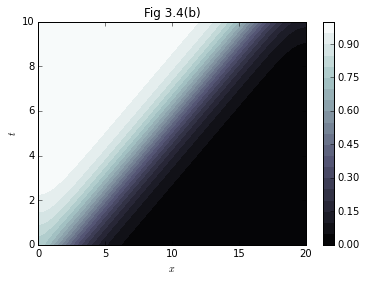

In [53]:
T=10; N=1e4; epsilon=1; a=20;
J=128; h=a/J; x=np.linspace(0,a,J+1)
u0=1/(1+np.exp(-(2-x)/sqrt(2)))
start=timer()
[t,ut]=pde_fd(u0,T,a,N,J,epsilon,fNagumo,'N')
end=timer()
print("Elapsed time", end-start, "secs")
#       
[T,X]=np.meshgrid(t,x)
ax = plt.gca()
#ax.plot_wireframe(T,X,ut,rstride=16,cstride=1000,colors='k')
CS=ax.contourf(X,T,ut,20,cmap=plt.cm.bone)
#ax.set_zlabel(r'$u$')
s=ax.set_xlabel(r'$x$')
s=ax.set_ylabel(r'$t$')
s=ax.set_title('Fig 3.4(b)')
s=plt.colorbar(CS)  

We start looking at the spectral Galerkin method.

In [54]:
fft=np.fft.fft
ifft=np.fft.ifft
def pde_oned_Gal(u0,T,a,N,J,epsilon,fhandle):
    """
    A3.5 Page 114
    """
    Dt=T/N; t=np.linspace(0,T,N+1); ut=np.zeros((J + 1,N + 1))
    # set linear operator 
    lam=(2 * pi/ a) * np.hstack([np.arange(0,J / 2+1), np.arange(- J / 2 + 1,0)]) 
    M=epsilon * lam ** 2
    EE=1.0 / (1 + Dt * M) # diagonal of (1+ Dt M)^{-1}
    ut[:,0]=u0;    u=u0[0:J];     uh=fft(u) # set initial condition
    #
    for n in range(0,N): # time loop
        fhu=fft(fhandle(u)) # evaluate fhat(u)
        uh_new=EE*(uh + Dt * fhu) # semi-implicit Euler step
        u=np.real(ifft(uh_new))
        ut[0:J,n + 1]=u
        uh=uh_new
    ut[J,:]=ut[0,:] # make periodic
    return t,ut

This is an example with the Allen-Cahn reaction term $f(u)=u-u^3$.

Elapsed time 0.121085886678 secs


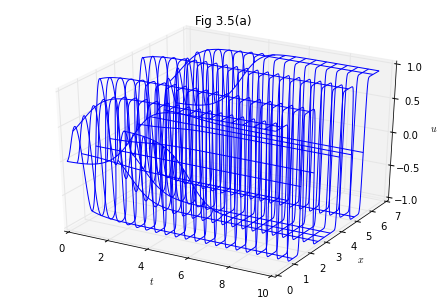

In [55]:
@vectorize([float64(float64)])
def fAC(u):
    return u-u**3
#
import mpl_toolkits.mplot3d.axes3d as p3
#
T=10;  N=1000;    a=2*pi;    J=512;    epsilon=1e-3
x=np.linspace(0,a,J+1);    u0=np.sin(4*x)*np.sin(x)
start=timer()
[t,ut]=pde_oned_Gal(u0,T,a,N,J,epsilon,fAC)
end=timer()
print("Elapsed time", end-start, "secs")
# Example
[T,X]=np.meshgrid(t,x)
fig=plt.figure()
ax = p3.Axes3D(fig)
ax.plot_wireframe(T,X,ut,rstride=32,cstride=50)  
s=ax.set_xlabel(r'$t$')
s=ax.set_ylabel(r'$x$')
s=ax.set_zlabel(r'$u$')
s=ax.set_title('Fig 3.5(a)') # only T=10 is shown in the book

The spectral Galerkin method is easily implemented in two dimensions on a square, because the eigenfunctions of the Laplacian are known and the two-dimensional FFT allows easy computations. 

In [56]:
fft2=np.fft.fft2
ifft2=np.fft.ifft2
def pde_twod_Gal(u0,T,a,N,J,epsilon,fhandle):
    """
    A3.6 Page 116
    """
    Dt=T / N;    t=np.linspace(0,T,N+1);
    ut=np.zeros((J[0] + 1,J[1] + 1,N+1))
    # set linear operators
    lambdax=(2*pi/a[0]) * np.hstack([np.arange(0,J[0] / 2+1), np.arange(- J[0] / 2 + 1,0)])
    lambday=(2*pi/a[1]) * np.hstack([np.arange(0,J[1] / 2+1), np.arange(- J[1] / 2 + 1,0)])
    lambdaxx,lambdayy=np.meshgrid(lambdax,lambday,indexing='ij')
    M=epsilon * (lambdaxx ** 2 + lambdayy ** 2)
    EE=1.0 / (1 + Dt * M)
    ut[:,:,0]=u0;  u=u0[0:-1,0:-1];  uh=fft2(u)# set initial data 
    for n in range(N): # time loop
        fhu=fft2(fhandle(u)) # compute fhat
        uh_new=EE*(uh + Dt * fhu)
        u=np.real(ifft2(uh_new))
        ut[0:J[0],0:J[1],n + 1]=u
        uh=uh_new
    ut[J[0],:,:]=ut[0,:,:]
    ut[:,J[1] ,:]=ut[:,0,:] # make periodic
    return t,ut

Here's an example with the Allen-Cahn equation on the domain $[2\pi,16]$.

In [57]:
T=10;    N=int(1e3);
a=[2*pi,16];    J=[128,256];
epsilon=1e-3
x=np.linspace(0,a[0],J[0]+1); y=np.linspace(0,a[1],J[1]+1); [xx,yy]=np.meshgrid(x,y,indexing='ij')
# initial data printed in book
#u0=np.sin(xx)*np.cos(pi*yy/8)
# we think he intended this initial data, which gives Fig 3.8b
u0=np.sin(yy)*np.cos(pi*xx/8);
start=timer()
[t,ut]=pde_twod_Gal(u0,T,a,N,J,epsilon,fAC)
end=timer()
print("Run time", end-start, "secs")

Run time 10.1070100439 secs


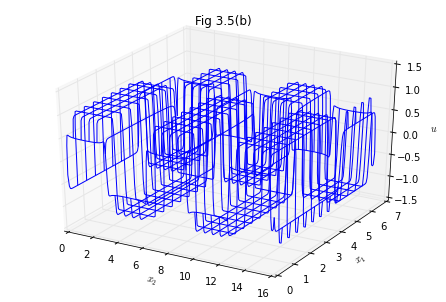

In [58]:
fig=plt.figure()
ax = p3.Axes3D(fig)
[xx,yy]=np.meshgrid(x,y)
ax.plot_wireframe(yy,xx,ut[:,:,-1].T,rstride=10,cstride=10)
s=ax.set_xlabel(r'$x_2$')
s=ax.set_ylabel(r'$x_1$')
s=ax.set_zlabel(r'$u$')
s=ax.set_title('Fig 3.5(b)')

The remaining sequence of codes explore the convergence behaviour of the spectral Galerkin and finite-element method in space (and semi-implicit Euler time stepping) for the reaction-diffusion equation. We start with the spectral Galerkin method.

In [59]:
def pde_oned_Gal_JDt(u0,T,a,Nref,kappa,Jref,J,epsilon,fhandle):
    """
    A3.7 Page 119
    """
    N=Nref // kappa
    Dt=T / N;    t=np.linspace(0,T,N+1)
    # iniitalize
    ut=np.zeros((Jref + 1,N + 1))
    # use IJJ to set unwanted modes to zero. 
    IJJ=np.arange(J / 2 + 1,Jref - J / 2,dtype='int' )
    # set linear operator
    lam=(2 * pi/a) * np.hstack([np.arange(0,Jref / 2+1), np.arange(- Jref / 2 + 1,0)]) 
    M=epsilon * lam ** 2;    EE=1.0 / (1 + Dt * M);    EE[IJJ]=0
    # set initial condition
    ut[:,0]=u0;    u=u0[0:Jref];    uh=fft(u)
    uh[IJJ]=0
    for n in range(N): # time loop
        fhu=fft(fhandle(u));        fhu[IJJ]=0
        uh_new=EE*(uh + Dt * fhu) # semi-implicit Euler step
        u=np.real(ifft(uh))
        ut[0:Jref,n+1]=u
        uh=uh_new;        uh[IJJ]=0
    ut[Jref ,:]=ut[0,:] # make periodic
    return t,ut
#
def pde_oned_Gal_convDt(u0,T,a,Nref,kappa,J,epsilon,fhandle):
    """
    A3.8 Page 119
    """
    # reference solution
    t,ureft=pde_oned_Gal_JDt(u0,T,a,Nref,1,J,J,epsilon,fhandle)
    S=np.empty_like(kappa,dtype='float64')
    for i, kappaval in np.ndenumerate(kappa):
        t,ut=pde_oned_Gal_JDt(u0,T,a,Nref,kappaval,J,J,epsilon,fhandle)
        S[i]=np.sum((ureft[0:-2,-1] - ut[0:- 2,-1]) ** 2) * (a / J)
    errT=np.sqrt(S)
    dtref=T / Nref
    dt=kappa * dtref
    return dt,errT
#
def pde_oned_Gal_convJ(u0,T,a,N,Jref,J,epsilon,fhandle):
    """
    A3.9 Page 120
    """
    # reference solution
    tref,ureft=pde_oned_Gal_JDt(u0,T,a,N,1,Jref,Jref,epsilon,fhandle)
    S=np.empty_like(J,dtype='float64')
    for i, Jval in np.ndenumerate(J):
        t,ut=pde_oned_Gal_JDt(u0,T,a,N,1,Jref,Jval,epsilon,fhandle)
        S[i]=np.sum((ureft[0:-2,-1] - ut[0:-2,-1]) ** 2) * a / Jref
    errJ=np.sqrt(S)
    return errJ

The routines above provide the necessary tools for exploring convergence in time and space. We do two experiments with the Allen-Cahn equation exploring convergence in $J$ (number of Fourier modes) and $\Delta t$ (time step).

In [60]:
epsilon=1; a=2*pi; J=1024
x=np.linspace(0,a,J+1);    u0=np.sin(4*x)*np.sin(x)
kappa=np.array([5,10,20,50,100,200],dtype='int')
T=10;    Nref=int(1e4)
[dt,errT]=pde_oned_Gal_convDt(u0,T,a,Nref,kappa,J,epsilon,fAC)

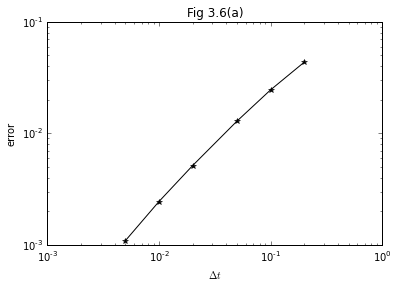

In [61]:
plt.loglog(dt,errT,'-k*')
s=plt.xlabel(r'$\Delta t$')
s=plt.ylabel(r'error')
s=plt.title(r'Fig 3.6(a)')

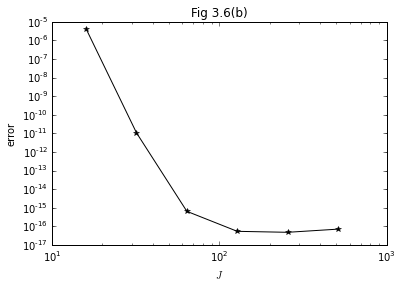

In [62]:
epsilon=1;    a=2*pi;    Jref=1024; N=int(1e4)
x=np.linspace(0,a,Jref+1)
u0=np.sin(4*x)*np.sin(x)
J=Jref*np.array([1/2,1/4,1/8,1/16,1/32,1/64])
T=10
errJ=pde_oned_Gal_convJ(u0,T,a,N,Jref,J,epsilon,fAC)
#
plt.loglog(J,errJ,'-k*')
s=plt.xlabel(r'$J$')
s=plt.ylabel(r'error')
s=plt.title(r'Fig 3.6(b)')

Let's turn to the spatial approximation by finite elements. We use the routines from Chapter 2 to work with the reaction-diffusion equation.

In [63]:
import ch2
#    
def oned_linear_FEM_b(ne,h,f):
    """
    A3.10 Page 122
    """
    nvtx=ne + 1
    elt2vert=np.vstack([np.arange(0,ne,dtype='int'),
                        np.arange(1,(ne + 1),dtype='int')])
    bks=np.zeros((ne,2));    b=np.zeros(nvtx) 
    bks[:,0]=f[:-1]*(h / 3) + f[1:]*(h / 6)
    bks[:,1]=f[:-1]*(h / 6) + f[1:]*(h / 3)
    for row_no in range(0,2):
        nrow=elt2vert[row_no,:]
        b[nrow]=b[nrow]+bks[:,row_no]
    b=b[1:-1]
    return b

def pde_fem(u0,T,a,N,ne,epsilon,fhandle):
    """
    A3.11 Page 122
    """
    h=a / ne;    nvtx=ne + 1;    Dt=T / N
    t=np.linspace(0,T,N+1)
    p=epsilon;    q=1;    f=1
    uh,A,b,KK,MM=ch2.oned_linear_FEM(ne,p,q,f)
    EE=(MM + Dt * KK);    ZM=0
    # set initial condition
    ut=np.zeros((nvtx,N + 1));    ut[:,0]=u0;     u=np.copy(u0)
    EEinv=sparse.linalg.factorized(EE)
    for n in range(N):# time loop
        fu=fhandle(u)
        b=oned_linear_FEM_b(ne,h,fu)
        u_new=EEinv(MM.dot(u[1:-1]) + Dt * b)
        u=np.hstack([ZM,u_new,ZM])
        ut[:,n + 1]=u
    return t,ut

Here's an example solution by the finite-element method for the Nagumo PDE.

In [64]:
T=10;    N=int(1e4); a=1;    ne=512;    h=a/ne; epsilon=1e-3
x=np.linspace(0,a,ne+1)
u0=np.exp(-(x-0.5)**2/epsilon)
start=timer()
[t,ut]=pde_fem(u0,T,a,N,ne,epsilon,fNagumo)
end=timer()
print("Run time", end-start, "secs") 

Run time 1.30310506855 secs


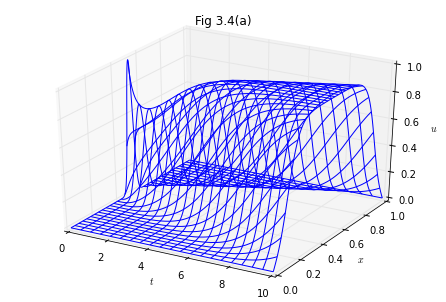

In [65]:
fig=plt.figure()
ax = p3.Axes3D(fig)
[T,X]=np.meshgrid(t,x)
ax.plot_wireframe(T,X,ut,rstride=16,cstride=500)
s=ax.set_zlabel(r'$u$')
s=ax.set_ylabel(r'$x$')
s=ax.set_xlabel(r'$t$')
s=ax.set_title(r'Fig 3.4(a)') # a more pleasing profile

Finally, let's examine the convergence of the finite-element approximation as the mesh width $h$ is refined.

In [66]:
def pde_fem_hDt(u0,T,a,Nref,kappa,neref,L,epsilon,fhandle):
    """
    A3.12 Page 123
    """
    ne=neref // L;    h=a / ne;    nvtx=ne + 1
    dtref=T / Nref;    Dt=kappa * dtref
    t=np.linspace(0,T, Nref // kappa)
    p=epsilon;    q=1;    f=1
    uh,A,b,K,M=ch2.oned_linear_FEM(ne,p,q,f)
    EE=M + Dt * K;    ZM=0
    # set initial condition
    ut=np.zeros((nvtx, Nref // kappa + 1));    ut[:,1]=u0;    u=np.copy(u0)
    EEinv=sparse.linalg.factorized(EE)
    for n in range(Nref // kappa): # time loop
        fu=fhandle(u)
        b=oned_linear_FEM_b(ne,h,fu)
        u_new=EEinv(M.dot(u[1:-1]) + Dt * b)
        u=np.hstack([ZM,u_new,ZM])
        ut[:,n + 1]=u
    return t,ut

def pde_fem_convh(u00,T,a,N,neref,L,epsilon,fhandle):
    """
    A3.13 Page 124
    """
    href=a / neref;    xref=np.linspace(0,a,neref+1)
    kappa=1
    t,uref=pde_fem_hDt(u00,T,a,N,kappa,neref,1,epsilon,fhandle)
    h=np.zeros(L.shape);    S=np.zeros(L.shape);
    for j, Lval in np.ndenumerate(L):
        h[j]=href * Lval
        u0=u00[::Lval]
        t,u=pde_fem_hDt(u0,T,a,N,kappa,neref,Lval,epsilon,fhandle)
        x=np.linspace(0,a, neref//Lval+1)
        uinterp=np.interp(xref,x,u[:,-1])
        S[j]=np.sum(uref[:,-1] - uinterp) ** 2 * href
    err=np.sqrt(S)
    return h,err

With the above tools, we run an example with the Nagumo equation and linear convergence is observed.

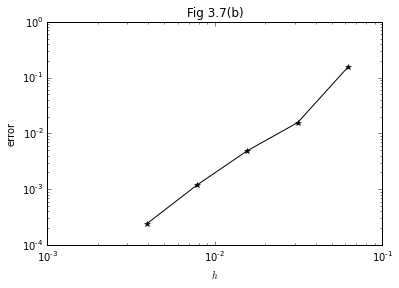

In [67]:
T=1; N=int(1e4); kappa=1; epsilon=1e-3
neref=512;  a=1
L=np.array([2,4,8,16,32],dtype='int')
href=a/neref
x=np.linspace(0,a,neref+1)
u0=np.exp(-(x-0.5)**2/epsilon)
h,errh=pde_fem_convh(u0,T,a,N,neref,L,epsilon,fNagumo)
#    
plt.loglog(h,errh,'k-*')
s=plt.xlabel(r'$h$')
s=plt.ylabel(r'error')
s=plt.title(r'Fig 3.7(b)')